# Metric Benchmark

L'objectif de ce notebook est d'étudier la pertinence d'utiliser une autre métrique que la *LogLoss* Multiclass classique, dans le cadre de notre classification multiclass.

## I. Dataset loading

In [55]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
import sklearn.metrics as skl
import matplotlib.pyplot as plt
import os
import shutil
import random as rd
import numpy as np

homePath = "C:/Users/thoma/OneDrive - CentraleSupelec/NOPLP/code/ML"

# Import du fichier util
shutil.copy(homePath + "/util.py", homePath + "/etudes/")
import util

os.chdir(homePath)

# Chargement du dataset
print("Dataset loading...")
df = pd.read_csv("data/lossBenchmarkData.csv", sep=";")

# Data Cleaning
print("Data cleaning...")
df = df.drop(columns=['Unnamed: 0', 'id', 'Chanson_id'])
reversed_cat = {'50': 1, '40': 2, '30': 3,
                '20': 4, '10': 5, 'MC': 6, '20k': 7, None: 8}
df = df.replace({'categorie': reversed_cat})

# Split train / test
print("Spliting in train and test...")
train = df[0:int(len(df)*0.8)]
print("Taille du dataset de train : " + str(len(train)))
test = df[int(len(df)*0.8)+1:]
print("Taille du dataset de test : " + str(len(test)))
train_labels = train['categorie']
trainSL = train.drop(columns=['categorie'])
train_data = trainSL
test_labels = test['categorie']
test = test.drop(columns=['categorie'])
test_data = test
test_pool = Pool(test_data,
                 test_labels,
                 cat_features=['titre', 'artiste'])

Dataset loading...
Data cleaning...
Spliting in train and test...
Taille du dataset de train : 206130
Taille du dataset de test : 51532


## II. Multiclass

Let's test the Multiclass metric, with and without weight balancing

### 1. Sans poids

In [32]:
# Training model
cat_features = ['titre', 'artiste']
model = util.trainModel(train_data, train_labels, cat_features)

Training the CatBoost model...


Predicting on the test set...
Confusion matrix :


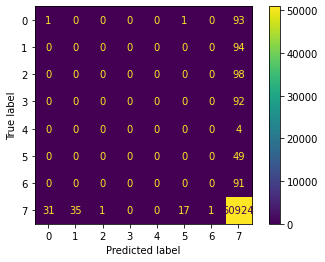

P5 = 0.0
P6 = 0.0
Precision = 0.0
R5 = 0.0
R6 = 0.0
Recall = 0.0
F1-score = 0


{'Precision': 0.0, 'Recall': 0.0, 'F1score': 0}

In [33]:
# Confusion matrix
confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)
dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
dispCM.plot()
plt.show()

# Calcul des métriques
util.metricCalculation(confusionMatrix)

C'est de la demer

### 2. Avec poids

In [34]:
# Training model
cat_features = ['titre', 'artiste']
class_weight = [0.1, 0.1, 0.1, 0.1, 0.1, 2, 1, 0.1]
print("Training the CatBoost model...")
model = CatBoostClassifier(iterations=10,
                            depth=10,
                            learning_rate=1,
                            loss_function='MultiClass',
                            class_weights=class_weight,
                            verbose=False)
model.fit(train_data, train_labels, cat_features=cat_features)

Training the CatBoost model...


Predicting on the test set...
Confusion matrix :


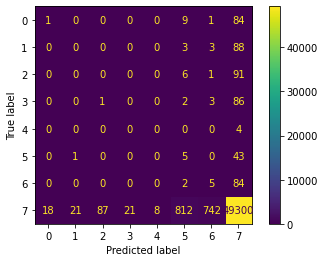

P5 = 10.2
P6 = 5.5
Precision = 9.7
R5 = 0.6
R6 = 0.7
Recall = 0.6
F1-score = 1.1


{'Precision': 9.7, 'Recall': 0.6, 'F1score': 1.1}

In [35]:
# Confusion matrix
confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)
dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
dispCM.plot()
plt.show()

# Calcul des métriques
util.metricCalculation(confusionMatrix)

**Conclusion :** C'est un peu mieux mais ça reste de la demer. Pour une prédiction juste, on fait 100 erreurs.

## III. Multiclass One Vs All

### 1. Sans poids

In [36]:
# Training model
print("Training the CatBoost model...")
model = CatBoostClassifier(iterations=10,
                            depth=10,
                            learning_rate=1,
                            loss_function='MultiClassOneVsAll',
                            verbose=False)
model.fit(train_data, train_labels, cat_features=cat_features)

Training the CatBoost model...


Predicting on the test set...
Confusion matrix :


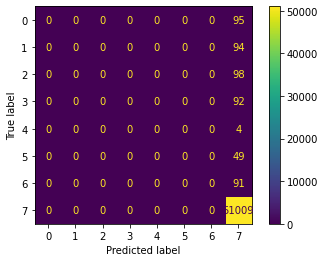

P5 = 0.0
P6 = 0.0
Precision = 0.0
R5 = 0
R6 = 0
Recall = 0.0
F1-score = 0


{'Precision': 0.0, 'Recall': 0.0, 'F1score': 0}

In [37]:
# Confusion matrix
confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)
dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
dispCM.plot()
plt.show()

# Calcul des métriques
util.metricCalculation(confusionMatrix)

C'est pire !

### 2. Avec poids

In [49]:
print("Training the CatBoost model...")
class_weight = [0.1, 0.1, 0.1, 0.1, 0.1, 2, 1, 0.1]
model = CatBoostClassifier(iterations=10,
                            depth=10,
                            learning_rate=1,
                            loss_function='MultiClassOneVsAll',
                            class_weights=class_weight,
                            verbose=False)
model.fit(train_data, train_labels, cat_features=cat_features)

Training the CatBoost model...


Predicting on the test set...
Confusion matrix :


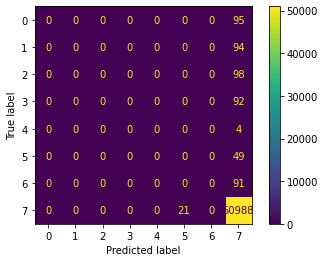

P5 = 0.0
P6 = 0.0
Precision = 0.0
R5 = 0.0
R6 = 0
Recall = 0.0
F1-score = 0


{'Precision': 0.0, 'Recall': 0.0, 'F1score': 0}

In [48]:
# Confusion matrix
confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)
dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
dispCM.plot()
plt.show()

# Calcul des métriques
util.metricCalculation(confusionMatrix)

**Conclusion :** La méthode OneVsAll avec poids performe légèrement mieux que la méthode classique.

## IV. Grid Search pour les poids

On remarque donc que ce qui fonctionne le mieux est la loss OneVsAll avec des poids. On cherche maintenant à optimiser les poids à mettre sur chaque classe pour maximiser notre *F1-score* customisé.

In [53]:
petites = [0, 0.1, 0.3, 0.5, 1]
grandes = [0.25, 0.5, 1, 2, 5, 10]

N = 20
res = []

for i in range(N):
    
    # On choisit des poids au hasard
    class_weight = [petites[rd.randint(0,4)], petites[rd.randint(0,4)], petites[rd.randint(0,4)], petites[rd.randint(0,4)], petites[rd.randint(0,4)], grandes[rd.randint(0,4)], grandes[rd.randint(0,4)], petites[rd.randint(0,4)]]
    print(class_weight)
    # On entraine le modèle
    model = CatBoostClassifier(iterations=10,
                            depth=10,
                            learning_rate=1,
                            loss_function='MultiClassOneVsAll',
                            class_weights=class_weight,
                            verbose=False)
    model.fit(train_data, train_labels, cat_features=cat_features)
    # On calcule la matrice de confusion
    confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)
    dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
    # On calcule le F1-score
    metriques = util.metricCalculation(confusionMatrix)

    res.append(class_weight + [metriques["F1score"]])

[0.5, 0, 0, 0, 0.1, 2, 2, 0]
Predicting on the test set...
Confusion matrix :
P5 = 55.1
P6 = 81.3
Precision = 57.7
R5 = 0.6
R6 = 0.2
Recall = 0.4
F1-score = 0.8
[0.5, 0.3, 1, 0, 0.5, 1, 2, 0.3]
Predicting on the test set...
Confusion matrix :
P5 = 0.0
P6 = 0.0
Precision = 0.0
R5 = 0
R6 = 0.0
Recall = 0.0
F1-score = 0
[0.1, 1, 1, 1, 0.1, 0.25, 5, 0.5]
Predicting on the test set...
Confusion matrix :
P5 = 0.0
P6 = 0.0
Precision = 0.0
R5 = 0
R6 = 0.0
Recall = 0.0
F1-score = 0
[1, 0.1, 0.1, 1, 0.3, 0.25, 5, 0.3]
Predicting on the test set...
Confusion matrix :
P5 = 0.0
P6 = 0.0
Precision = 0.0
R5 = 0
R6 = 0.0
Recall = 0.0
F1-score = 0
[0.1, 0.3, 0.1, 0.3, 0, 5, 0.5, 0.3]
Predicting on the test set...
Confusion matrix :
P5 = 2.0
P6 = 0.0
Precision = 1.8
R5 = 0.9
R6 = 0
Recall = 0.4
F1-score = 0.7
[0.5, 0.5, 1, 0.1, 0.1, 1, 0.5, 0.3]
Predicting on the test set...
Confusion matrix :
P5 = 0.0
P6 = 0.0
Precision = 0.0
R5 = 0
R6 = 0
Recall = 0.0
F1-score = 0
[0, 0.3, 0.1, 0, 0, 0.25, 0.5, 1]
Pre

In [56]:
dfRes = pd.DataFrame(np.array(res), columns = ["50", "40", "30", "20", "10", "MC", "20k", "PP", "F1score"])
dfRes.sort_values(by = "F1score", ascending = False)

,50,40,30,20,10,MC,20k,PP,F1score
10,1.0,0.0,0.1,0.5,0.1,5.00,5.00,0.1,1.8
8,0.3,0.1,0.5,0.0,0.5,5.00,0.50,0.1,1.1
18,1.0,0.1,0.0,0.0,1.0,5.00,5.00,0.0,0.8
16,0.0,1.0,0.5,0.0,0.1,1.00,1.00,0.0,0.8
9,0.1,0.3,0.5,0.1,0.0,5.00,0.25,0.0,0.8
0,0.5,0.0,0.0,0.0,0.1,2.00,2.00,0.0,0.8
19,0.5,0.0,1.0,0.5,0.0,5.00,0.25,0.0,0.8
4,0.1,0.3,0.1,0.3,0.0,5.00,0.50,0.3,0.7
12,0.1,0.5,0.0,0.5,0.5,5.00,1.00,0.3,0.7
13,0.3,0.5,0.5,0.5,0.1,5.00,0.25,0.1,0.7
